取引価格（総額）_log    1.000000
建築年             0.537253
面積（㎡）           0.370673
容積率（％）          0.118265
取引時点            0.089068
建ぺい率（％）         0.029017
市区町村コード        -0.157818
最寄駅：距離（分）      -0.192006
Name: 取引価格（総額）_log, dtype: float64


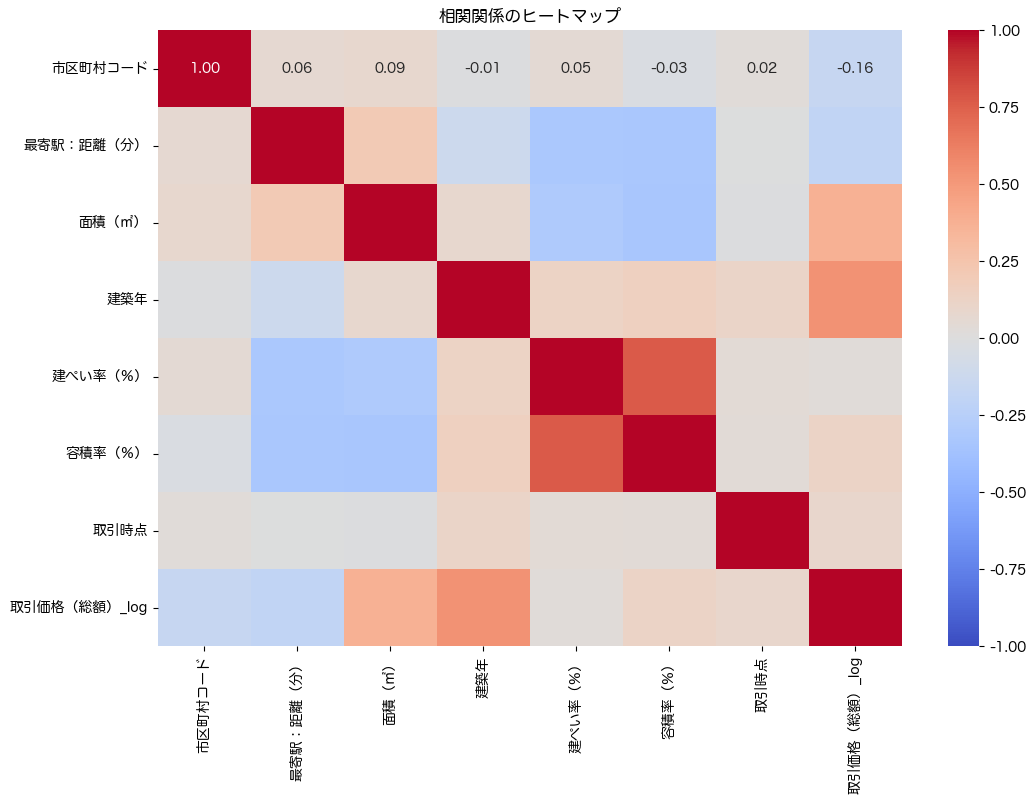

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/data/train/train_cleaned3/combined_all_train_最寄駅_面積（㎡）_建築年_建ぺい率（％）_容積率（％）_取引時点_取引価格（総額）_log.csv'
data_cleaned = pd.read_csv(data_path)

# 日本語フォントの設定
plt.rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro']  # Mac用
plt.rcParams['axes.unicode_minus'] = False

# '間取り'と'建物の構造'列を除外
data_numeric = data_cleaned.drop(columns=['間取り', '建物の構造'])

# 数値列の相関関係を計算
correlation_matrix = data_numeric.corr()

# '取引価格（総額）_log'との相関が高い列を取得
correlation_with_price = correlation_matrix['取引価格（総額）_log'].sort_values(ascending=False)

# 相関関係の確認
print(correlation_with_price)

# ヒートマップの作成
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('相関関係のヒートマップ')
plt.show()
  


# 新しい特徴量を作成する

In [5]:
import pandas as pd
import numpy as np

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/data/train/train_cleaned3/combined_all_train_最寄駅_面積（㎡）_建築年_建ぺい率（％）_容積率（％）_取引時点_取引価格（総額）_log.csv'
data_cleaned = pd.read_csv(data_path)

# 価格/面積比を計算
data_cleaned['価格/面積比'] = data_cleaned['取引価格（総額）_log'] / data_cleaned['面積（㎡）']

# 取引時点から年を抽出
data_cleaned['取引年'] = data_cleaned['取引時点'].astype(str).str[:4].astype(int)

# 築年数を計算（取引年 - 建築年）
data_cleaned['築年数'] = data_cleaned['取引年'] - data_cleaned['建築年']

# 取引月を抽出
data_cleaned['取引月'] = data_cleaned['取引時点'].apply(lambda x: int(str(x)[4:6]))

# 面積/築年数比を計算
data_cleaned['面積/築年数比'] = data_cleaned['面積（㎡）'] / data_cleaned['築年数']

# エリア人気度スコアの計算
area_popularity = data_cleaned.groupby('市区町村コード')['取引価格（総額）_log'].mean().reset_index()
area_popularity.columns = ['市区町村コード', 'エリア人気度スコア']
data_cleaned = data_cleaned.merge(area_popularity, on='市区町村コード', how='left')

# 年別価格トレンドの計算
yearly_trend = data_cleaned.groupby('取引年')['取引価格（総額）_log'].mean().reset_index()
yearly_trend.columns = ['取引年', '年別価格トレンド']
data_cleaned = data_cleaned.merge(yearly_trend, on='取引年', how='left')

# 価格増加率の計算
data_cleaned['価格増加率'] = data_cleaned['取引価格（総額）_log'].pct_change().fillna(0)

# 駅距離/面積の計算
data_cleaned['駅距離_面積比'] = data_cleaned['最寄駅：距離（分）'] / data_cleaned['面積（㎡）']

# 容積率と建ぺい率の比率
data_cleaned['容積率_建ぺい率比'] = data_cleaned['容積率（％）'] / data_cleaned['建ぺい率（％）']

# 面積と容積率の交互作用
data_cleaned['面積×容積率'] = data_cleaned['面積（㎡）'] * data_cleaned['容積率（％）']

# 建築年と建ぺい率の交互作用
data_cleaned['建築年×建ぺい率'] = data_cleaned['建築年'] * data_cleaned['建ぺい率（％）']

# 新しい特徴量を含むデータの確認
print(data_cleaned.head())

# データを保存
data_cleaned_path = '/Users/hayakawakazue/Downloads/data/train/train_cleaned4/combined_all_train_cleaned_with_features.csv'
data_cleaned.to_csv(data_cleaned_path, index=False)

print(f"データを保存しました: {data_cleaned_path}")
print(data_cleaned.dtypes)


   市区町村コード  最寄駅：距離（分）   間取り  面積（㎡）     建築年 建物の構造  建ぺい率（％）  容積率（％）      取引時点  \
0     1108        8.0  ３ＬＤＫ   80.0  1995.0   ＳＲＣ     60.0   200.0  200912.0   
1     1101        5.0   １ＤＫ   30.0  1982.0   ＳＲＣ     80.0   300.0  201809.0   
2     1101       11.0  ３ＬＤＫ   65.0  1991.0   ＳＲＣ     80.0   300.0  201006.0   
3     1108        5.0  ４ＬＤＫ   90.0  2015.0    ＲＣ     80.0   400.0  201509.0   
4     1108       12.0  ４ＬＤＫ   80.0  1982.0    ＲＣ     60.0   200.0  201212.0   

   取引価格（総額）_log  ...   築年数  取引月   面積/築年数比  エリア人気度スコア  年別価格トレンド     価格増加率  \
0      7.079181  ...  14.0   12  5.714286   7.095538  7.209604  0.000000   
1      6.755875  ...  36.0    9  0.833333   7.111982  7.287327 -0.045670   
2      7.204120  ...  19.0    6  3.421053   7.111982  7.219128  0.066349   
3      7.591065  ...   0.0    9       inf   7.095538  7.240474  0.053712   
4      6.875061  ...  30.0   12  2.666667   7.095538  7.197796 -0.094322   

    駅距離_面積比  容積率_建ぺい率比   面積×容積率  建築年×建ぺい率  
0  0.100000   3.333333  